# Illustrating whitebox adversarial attacks 
Lucas Anquetil & Stéphane Canu, LITIS, INSA Rouen Normandie
## How to build adversarial exemples and define the robustness of a classifier?

Recent results have shown that neural networks are vulnerable to so-called adversarial attacks, that is, subtle input disturbances that may be too small to be noticeable, but nevertheless capable of fooling deep learning models.

This notebook implements main methods to generate such adversarial examples in a white box setting, with the CIFAR10 dataset using a 3-layer perceptron as a neural network implemented with pytorch, in order to compare their efficiency both in terms of precision and computation time.

Are implemented:
- Evasion attack
- Fast Gradient Sign Method attack
- Projected Gradient Method attack
- Carlini & Wagner attack
- The MIP-ReLUplex attacks using either $L_2$ and $L_\infty$ distance measures
- The accelerated MIP-ReLUplex attacks using bounds

<img src="https://www.cs.umd.edu/~tomg/img/free/viz_9985_10000_small.png" 
alt="CIFAR10 data" width="360" height="270" border="1" />
<p style="text-align: center;"> <i>Illustration from the Adversarial Training for Free! web site </i> https://www.cs.umd.edu/~tomg/projects/free/</p>
    
    
For more details on adversarial exemple see for instance https://nicholas.carlini.com/writing/2018/adversarial-machine-learning-reading-list.html   
For proper code see for instance:
- CleverHans https://github.com/tensorflow/cleverhans
- The adversarial robustness toolbox (ART) https://github.com/Trusted-AI/adversarial-robustness-toolbox
- Robust ML https://www.robust-ml.org/
- Advertorch https://advertorch.readthedocs.io/en/latest/advertorch/attacks.html
- MIPVerify http://vtjeng.com/MIPVerify.jl/stable/


To properly execute this jupyter notebook you need to have the following Python Packages installed
 - pytorch: ```pip3 install torch torchvision```
 - cvxpy: ```pip3 install cvxpy```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from copy import deepcopy
import cvxpy as cp
from time import time

## Loading data and training a neural network

We will be using the CIFAR10 dataset, in which there ares images belonging to $c = 10$ possible labels.

A 3 layered MLP of one hidden layer of $e = 100$ neurons : $f, f : \mathbb{R}^{p} \mapsto \mathbb{R}^{c}, p = 3 \times 32 \times 32$ will be trained on this data. Input data (initially coded between 0 and 1) is normalize beteen -1 and 1.


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 150, bias=True)
        self.fc2 = nn.Linear(150, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x.reshape(-1, 3*32*32)))
        x = self.fc2(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


Training the MLP on classification with a KL objective :
$\displaystyle \min_{\theta}D_{KL}(P_{data}\vert\vert f^{\theta}) = \max_{\theta} \mathbb{E}_{x \sim P_{data}}[\log(f^{\theta}(x))]$

https://zhenye-na.github.io/2018/09/28/pytorch-cnn-cifar10.html

In [3]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
mlp = MLP()
optimizer = optim.Adam(mlp.parameters(), lr=0.0001, weight_decay=2e-4)

nb_ite_max = 20
for epoch in tqdm(range(nb_ite_max)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
#        running_loss += loss.item()
#        if i % 2000 == 1999:    # print every 2000 mini-batches
#            print('[%d, %5d] loss: %.3f' %
#                  (epoch + 1, i + 1, running_loss / 2000))
#            running_loss = 0.0

#print('Finished Training')
#PATH = './cifar_mlp.pth'
#torch.save(mlp.state_dict(), PATH)
#mlp.load_state_dict(torch.load(PATH))

100%|██████████| 20/20 [17:40<00:00, 53.04s/it]


The resulting network is not very good, but small enough to allow fairly fast simulations and coherent with previously reported results (https://arxiv.org/pdf/1611.03530.pdf?from=timeline&isappinstalled=0)

See also: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8451092&casa_token=sokdpm5XAHgAAAAA:ZltEd8NqXeS41tOtHsZf9IFd8qzpxyY5txJJu0S3g-J3hdNXcFmCDvydm_Y3bkJ6h_SE6WoQ1uo

In [4]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = mlp(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 51 %


A useful functions to look to images

In [5]:
def imshow(img, fig):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

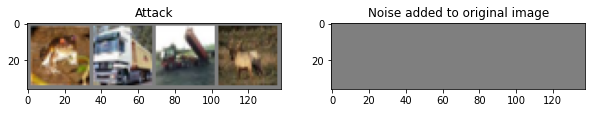

 frog truck truck  deer
Predicted:   frog truck truck  frog


In [6]:
def plot_attack_pred(original, attack, classifier, n_images=1):
  # show image and noise
  ax, fig = plt.subplots(nrows=1,ncols=2, figsize=(10,8))
  fig[0].set_title("Attack")
  imshow(torchvision.utils.make_grid(attack), fig[0])
  noise = (original - attack).detach()
  fig[1].set_title("Noise added to original image")
  imshow(10*torchvision.utils.make_grid(noise), fig[1])
  plt.show()
  # print labels
  print(' '.join('%5s' % classes[labels[j]] for j in range(n_images)))
  outputs = classifier(attack)
  _, predicted = torch.max(outputs, 1)
  print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                for j in range(n_images)))

# to test the plot function and check the predicted classes
plot_attack_pred(images, images, mlp, n_images=4)

image_to_attack = images[0]
image_to_attack.requires_grad = True
class_img = predicted[0].unsqueeze(0)
class_target = torch.tensor([0])

## Definition of adversarial exemples

A classification model (e.g. Neural Network) with $c$  output nodes  (possible classes)
\begin{equation*}
	\begin{array}{cccl}
		f : {} & X \subseteq \mathbb{R}^p &  \longrightarrow&  \mathbb{R}^c  \\ %  \{0,1\}^c \\
		{} & x &  \longmapsto& f(x)
	\end{array}
	\label{function-neural-network}
\end{equation*}
The associated classification (or decision function) 
$$
C_f(x) = argmax_{k=1,\dots,c} f_k(x)
$$

Definition (Generic adversarial example): 
$\mathbf{a}_{f,x}$ is a generic adversarial example of $f$ at $x$ if $\mathbf{a}_{f,x}$ is a valid input close to $x$  and    
$$ 
C_f(x) \neq C_f(\mathbf{a}_{f,x})
\quad \mbox{ that is } \quad 
 \displaystyle  {c^\star} =  argmax_{k=1,\dots,c} f_k(x) \neq argmax_{k=1,\dots,c} f_k(\mathbf{a}_{f,x})
 $$


__1. Evasion Attacks against Machine Learning at Test Time Biggio, et al., ECML 2013__


It is proposed to find $\mathbf{a}_{f,x}$ by adressing the following optimization problem:
	\begin{equation}
		\left\{
		\begin{array}{cl}
			\displaystyle \min_{a \in X}  & f_{c^\star}(a)\\
			\text{subject to} &  \displaystyle \|x-a\| \leq \delta   \; .
		\end{array}
		\right.
	\end{equation}
        
 where $\displaystyle {c^\star} = argmax_{k=1,\dots,c} f_i(x)$, 		
with one step of projected gradient descent (and $\rho$ large enough)
\begin{equation}
	\mathbf{a}_{f,x} = \mbox{Proj}_{\mathcal{A}_x} \bigl(x - \; \rho \; \nabla_{x}  f_i(x)\bigr)
\end{equation}
 where 
$$
	\mathcal{A}_x = \bigl\{a \in X  \; | \;  \|x-a\| \leq \delta \bigr\}
$$
Note that the strategy to set the stepsize $\rho$ can be discussed more into details.

In [7]:
def projection(x,delta):
    norm_x = torch.norm(x)
    if norm_x > delta:
        x_proj = x/(norm_x*delta)
    else:
        x_proj = x
    return x_proj

def evasion_attack(x, classifier, delta=30, rho=0.01): 
  criterion = nn.CrossEntropyLoss()
  f_x = classifier(x)
  _, index = f_x.sort()
  c_a = index[0][-2]
  a = x.clone().detach()
  a.requires_grad = True
  f_a = classifier(a)
  loss = criterion(f_a, c_a.unsqueeze(0))
  loss.backward()
  a_grad = a.grad.clone().detach()
  
  while(f_a[0].max() != f_a[0][c_a]):
    a = x.clone().detach()
    a = a - rho*a_grad
    a = projection(a, delta)
    f_a = classifier(a)
    rho = rho + 0.01

  return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


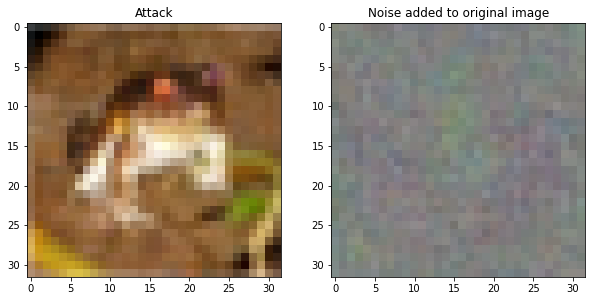

 frog
Predicted:    cat


In [8]:
s = time()
a_evasion = evasion_attack(image_to_attack.unsqueeze(0), classifier=mlp)
evasion_attack_time = time() - s
a_evasion = a_evasion.detach()
plot_attack_pred(image_to_attack, a_evasion, mlp)

__2. Fast Gradient Sign Method (FGSM), (I. Goodfellow et al, ICLR 2015)__

Fast Gradient Sign Method (FGSM) proposed to find $\mathbf{a}_{f,x}$ by adressing the following optimization problem, given $(x,t)$   
\begin{equation}
		\left\{
\begin{array}{cl}
\displaystyle 	\max_{a \in X}  &J\bigl(f(a),t\bigr) \qquad \mbox{training loss}\\
	\text{subject to} &   \|x-a\| \leq \delta   
\end{array}
\right.
\end{equation}

with one step of projected gradient sign descent 
  ($\rho$ large enough)

$$
\mathbf{a}_{f,x} \; = \; x \; {+} \;  \rho \; \mbox{sign}\Bigl(\nabla_x J\bigl(f(x),t\bigr)\Bigr)
$$

Differences with Evasion Attack is the cost function to be maximize and the choice of using the sign of the gradient as descent direction 

For more details, see for instance 
https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [9]:
def fgsm_attack(x, classifier, delta=30, rho=0.002):
  criterion = nn.CrossEntropyLoss()
  a = x.clone().detach()
  a.requires_grad = True
  f_x = classifier(x)
  _, index = f_x.sort()
  c_x = index[0][-1]
  f_a = classifier(a)
  loss = criterion(f_a, c_x.unsqueeze(0))
  loss.backward()
  a_grad = a.grad

  while(f_a[0].max() == f_a[0][c_x]): 
    a = x.clone().detach()
    a = a + rho*torch.sign(a_grad)
    a = projection(a, delta)
    f_a = classifier(a)
    rho = rho + 0.002

  return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


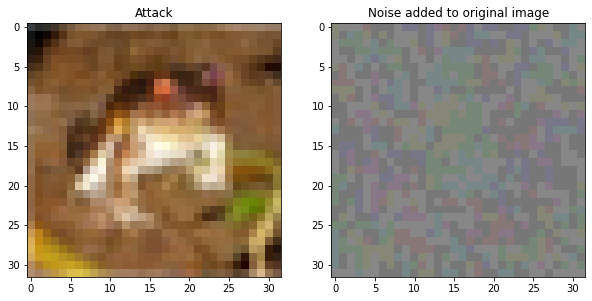

 frog
Predicted:    cat


In [10]:
s = time()
a_fsgm = fgsm_attack(image_to_attack.unsqueeze(0), classifier=mlp)
fgsm_attack_time = time() - s
a_fsgm = a_fsgm.detach()
plot_attack_pred(image_to_attack, a_fsgm, mlp)

__3. Projected gradient descent (PGD)__


The  i-FGSM (PGD) proposed solution consist in building a sequence with (small) $\rho_{i}$
to solve the FGSM problem:
$$
\left\{	\begin{array}{l}
	a_{0} = x \\ 
	a_{i+1} =  \mbox{Proj}_{\mathcal{A}} \Bigl(a_{i}  \; +\;    \rho_i \; \mbox{sign}\Bigl(\nabla_x J\bigl(f(a_{i}),c^\star\bigr)\Bigr) 
\end{array}
\right.
$$

Note that: 
 - $\rho$ chosen to change the value of each pixel only by 1 on each step
 - due to the non concavity,  it only  converges towards local maxima
 - i-FGSM is equivalent to (the $\ell_\infty$ version of) Projected Gradient Descent (PGD), Madry et al., ICLR 2018 (up to the sign?)
 - Specific version: with $t$ the target class  
$$
	a_{i+1} =  \mbox{Proj}_{\mathcal{A}} \Bigl(a_{i}  \; -\;    \rho_i \; \mbox{sign}\Bigl(\nabla_x J\bigl(f(a_{i}),t\bigr)\Bigr) 
$$


In [11]:
def pgd(x, classifier, delta=30, rho=0.000025):
  f_x = classifier(x)
  _, index = f_x.sort()
  c_x = index[0][-1]
  a = x.clone().detach()
  a.requires_grad = True
  f_a = classifier(a)
  criterion = nn.CrossEntropyLoss()

  while(f_a[0].max() == f_a[0][c_x]):
    loss = criterion(f_a, c_x.unsqueeze(0))
    loss.backward()

    a = a + rho*torch.sign(a.grad)
    a = projection(a, delta)
    a = a.detach()
    a.requires_grad = True
    loss = None
    f_a = classifier(a)
  return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


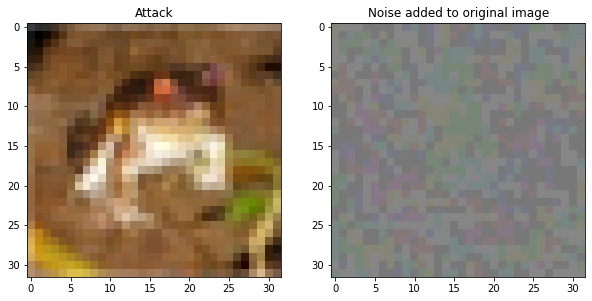

 frog
Predicted:    cat


In [12]:
s = time()
a_pgd = pgd(image_to_attack.unsqueeze(0), classifier=mlp)
pgd_attack_time = time() - s
a_pgd = a_pgd.detach()

outputs = mlp(a_pgd)
_, predicted = torch.max(outputs, 1)
pgd_target_class = predicted[0]

plot_attack_pred(image_to_attack, a_pgd, mlp)

__4. Universal Adversarial Perturbation__

Given $f$, 	find $a$ small s.t. for "most" $(x,c^\star)$ 
	$\displaystyle \max_{k \neq c^\star}f_k(x+a) > f_{c^\star}(x+\Delta)$
	
The problem can be formalized as follows:	
	$$   \left\{	
	\begin{array}{cl}
		\displaystyle \min_{\Delta}  & L\bigl(f(x+\Delta),t\bigr)  =  \Pr\left(\displaystyle \max_{k \neq c^\star}f_k(x+a) > f_{c^\star}(x + \Delta)\right) \\ % > 1-\epsilon \\		
		\mbox{subject to} &   \|\Delta \|_p \leq \delta  \\
		                          &    x+\Delta \in X
	\end{array}
\right.
	$$
	
The proposed solution involve 	Lagrangian formulation plus SGD on minibach.


In [13]:
def all_fooled(classifier, x, c_x):
  for k in range(x.shape[0]):
    if classifier(x[k]).argmax().item() == c_x[k].item():
      return False
  return True

def univ_pgd(x, classifier, delta=30, rho=0.001):
  f_x = classifier(x)
  _, index = f_x.sort()
  c_x = torch.tensor([index_k[-1] for index_k in index])
  noise = torch.zeros(x[0].shape).detach()
  noise.requires_grad = True
  x_v = x.clone().detach()
  for k in range(x.shape[0]):
     x_v[k] = x_v[k] + noise
  f_xv = classifier(x_v)
  criterion = nn.CrossEntropyLoss()

  while (not all_fooled(classifier, x_v, c_x)):
    loss = criterion(f_xv, c_x)
    loss.backward()

    noise = noise + rho*noise.grad
    noise = projection(noise, delta)
    noise = noise.detach()
    noise.requires_grad = True
    loss = None
    x_v = x.clone().detach()
    for k in range(x_v.shape[0]): 
      x_v[k] = x_v[k] + noise
    
    f_xv = classifier(x_v)

  return noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


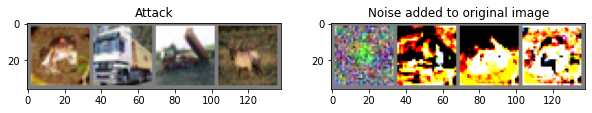

 frog
Predicted:  horse


In [14]:
s = time()
noise_univ = univ_pgd( images, classifier=mlp)
noise_univ_attack_time = time() - s
noise_univ = noise_univ.detach()
a_noise_univ = images.clone().detach()
for k in range(a_noise_univ.shape[0]): 
  a_noise_univ[k] = a_noise_univ[k] + noise_univ
plot_attack_pred(image_to_attack, a_noise_univ, mlp)

__5. Optimization attack: Carlini & Wagner (CW), 2017__

Carlini & Wagner defined specific attack. 
Given $x$ and  $\displaystyle  t \neq c^\star = argmax_{k=1,\dots,c} f_k(x)$, the atack is given by the solution of
$$
\left\{	
\begin{array}{cl}
	\displaystyle \min_{a \in X}  & D( x,a)  \\
	\mbox{subject to} &  C_f(a) =  t  \; 
\end{array}
\right.
$$
Their idea is to define an objective function $L$ such that  $C_f(a) =  t_a$ if  $L(f(a), t_a) \leq 0$
so that the optimisation probleme becoms

$$
	\left\{
	\begin{array}{cl}
		\displaystyle \min_{a \in X}  & D( x,a)  \\
		\mbox{subject to} & L(f(a), t)  \leq 0  \; 
	\end{array}
	\right.
	\qquad \text{ with the lagrangian formulation } \qquad 
	\begin{array}{cl}
		\displaystyle \min_{a \in X}  & D( x,a)  \;+\;  \lambda \; L(f(a), t_a)    \; 
	\end{array}
$$	


The Carlini & Wagner $\ell_2$ attack is with Euclidean distance $D( x,a)  = \|x-a\|_2^2$ 
and the hinge loss (with confidence $\alpha$)
$$
L\bigl(f(a), t\bigr)  = \max\bigl[\alpha - \bigl( f_ {t}(a)  - \max_{k \neq  t}  f_{k}(a)\bigr) ,0 \bigr]
$$
They propose to use stochastic gradient descent solver  to solve the optimization problem

Choices of $\alpha$, $\lambda$ and SGD optimizer parmaters (such as the stepsize) are critical.

In [15]:
def carlini_wagner_l2hinge(x, classifier, lam=1e-2, alpha=.01):
  a = x.clone().detach()
  a.requires_grad = True
  x_clone = x.clone().detach()

  f_a = classifier(a)
  f_x = classifier(x)
  optimizer = torch.optim.Adam([a])
  _, index = f_x.sort()
  c_a = index[0][-2]

  while(f_a[0].max() != f_a[0][c_a]):       # if lam is too small it turn out to be an infinite loop
    optimizer.zero_grad()
    loss = torch.norm(a - x_clone)
    loss = loss + lam * torch.max(alpha - (f_a[0][c_a] - f_a[0].max()), torch.tensor(0.))
    loss.backward()
    optimizer.step()
    f_a = classifier(a)
   
  return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


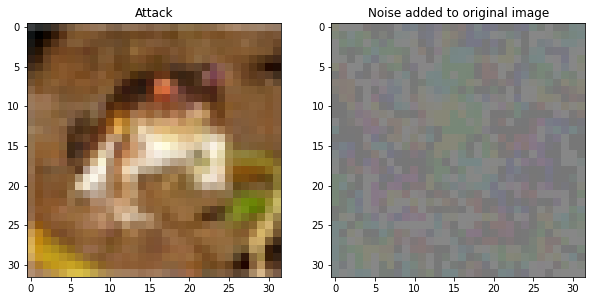

 frog
Predicted:    cat


In [16]:
s = time()
a_cw = carlini_wagner_l2hinge(image_to_attack.unsqueeze(0), classifier=mlp, lam=torch.tensor(1.))
carlini_wagner_time = time() - s
a_cw = a_cw.detach()
plot_attack_pred(image_to_attack, a_cw, mlp)

__6. The ReLUplex (Lomuscio & Maganti, Katz et al., 2017)__


It is also possible to exactly minimize the  Adversarial  Distortion (Bunel et al., NeurIPS 2018, Tjeng et al.,  ICLR 2019)
\begin{equation}
	\left\{
	\begin{array}{cclc}
		\displaystyle \min_{a \in X }  &D(x,a) &=&  \|x-a\|_p\\
		\text{subject to} & L\bigl(f(x),f(a)\bigr) \geq \alpha  &=&\displaystyle \max_{k \neq {c^\star}} f_k(a) >  f_{c^\star}(a) + \alpha
	\end{array}
	\right.
	\label{eq:MIP}
\end{equation}
In the particular case of a one hidden layer MLP with weighe $W$ and $V$ and biais $\beta$ and $\gamma$, function $f$ is
$$
	\begin{array}{rl}
		\displaystyle 
		z  & =  ReLU(W x + \beta)\\
		f(x) & = V z + \gamma
	\end{array}
	\quad \text{or}\quad 
	\begin{array}{rl}
		\displaystyle 
		h & = W x + \beta,\\
		z  & =  \max(h, 0)\\
		f(x) = s  & = V z + \gamma \,.
	\end{array}
$$
Based on that, the minimization of the  Adversarial  Distortion can be rewritten as a Mixed Integer Linear Program (MILP) thus can be solved by existing MILP solvers (ECOS_BB, GLPK, Gurobi, CPLEX, NAS...) 
\begin{equation} 	\left\{ \begin{array}{cll}
		\displaystyle \min_{ \substack{ a \in [0,1]^p, \\ b \in \{0,1\}^e} } & \| x - a \|_p^p& \\
		\text{subject to} & h  = W a + \beta &\\
		&{ z_{i}  \geq 0} &i = 1,\dots,e  \\
		&{ z_{i}  \leq M_r b_i } & i = 1,\dots,e  \\
		&{ z_{i}  \leq h_{i} + M_r (1-b_i)} & i = 1,\dots,e  \\
		&{z_{i}  \geq h_{i}} &i = 1,\dots,e \\
		& s   = V z + \gamma  &\\
		& \displaystyle  \max_{i\neq i^\star} s_i > s_{i^\star}&.
	\end{array}
	\right.
\end{equation}

Note that for $p=2$ this is a quadratic program while for $p=\infty$ it is a linear one, as well as for $p=1$.
To simplify the problem, and avoid unecessary additional binary variables, we set the target call as the second best, that is $\displaystyle c_a = \max_{i, i \neq c_x} f_i(x)$.


In [17]:
def reluplex_l2(classifier, original, solver, pnorm=2):

  f_x = classifier(original)
  values, indices = f_x.sort()
  class_img_index = indices[0][-1]
  class_target_index = indices[0][-2]
  
  # Construct the problem.
  attack_np = original.flatten().clone().detach().numpy()
  attack = cp.Variable(attack_np.shape[0])
  original_np = original.flatten().detach().numpy()
  original = cp.Parameter(original_np.shape[0], value=original_np)

  # Objective
  objective = cp.Minimize(cp.norm(original - attack, p=pnorm))

  # Network parameters
  W_np = classifier.fc1.weight.detach().numpy()
  W = cp.Parameter(W_np.shape, name='W', value=W_np)
  beta_np = classifier.fc1.bias.detach().numpy()
  beta = cp.Parameter(beta_np.shape, name='b', value=beta_np)
  H_np = classifier.fc2.weight.detach().numpy()
  H = cp.Parameter(H_np.shape, name='H', value=H_np)
  gamma_np = classifier.fc2.bias.detach().numpy()
  gamma = cp.Parameter(gamma_np.shape, name='g', value=gamma_np)
  h = cp.Variable(beta.shape, name='h')
  

  # The ReLU activation function trick
  z = cp.Variable(beta.shape, name='z')
  Mr = cp.Parameter(name='Mr', value=1e4)
  bin = cp.Variable(h.shape, boolean=True, name='b')
  s = cp.Variable(10, name='s')
  #s = cp.matmul(H, z) + gamma

  # Constraints
  constraints = [s == cp.matmul(H, z) + gamma, h == cp.matmul(W, attack) + beta,
                 bin >= 0, bin <= 1, z >= 0, z >= h, z <= (Mr * bin),
                      z <= (Mr * (1-bin)) + h]
                      
  # Contrainsts on the output using a slack variable
  eps = cp.Parameter(name="epsilon", value=1e-5)
  constraints.extend([s[class_target_index] >= s[class_img_index] + eps])

  problem = cp.Problem(objective, constraints)
  problem.solve(verbose=False, solver=solver, TimeLimit=900)
  return attack.value
  # ECOS_BB, GLPK_MI

In [18]:
cp.installed_solvers()

['ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCS']

Using license file /Users/stephane/gurobi.lic
Academic license - for non-commercial use only


/Users/stephane/opt/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


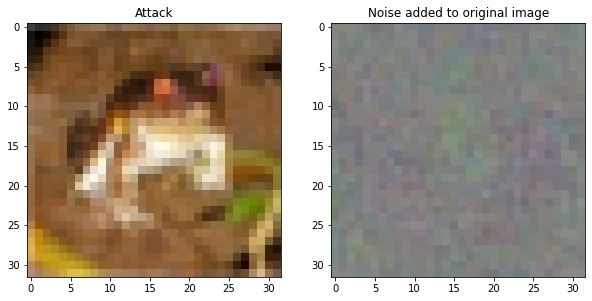

 frog
Predicted:    cat


In [19]:
s = time()
a_reluplex_ECOS_BB = reluplex_l2(mlp, image_to_attack, solver=cp.GUROBI, pnorm=2)
reluplex_ECOS_BB_time = time() - s
a_reluplex_ECOS_BB = torch.tensor(a_reluplex_ECOS_BB).reshape((3,32,32)).type(torch.float)
plot_attack_pred(image_to_attack, a_reluplex_ECOS_BB, mlp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


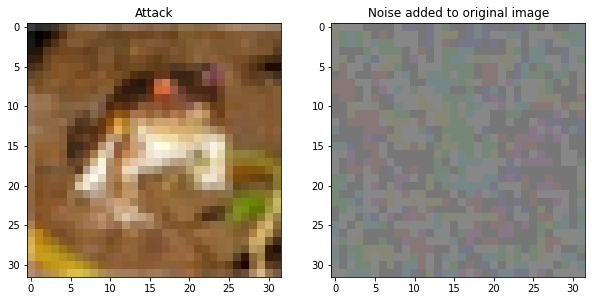

 frog
Predicted:    cat


In [20]:
s = time()
a_reluplex_GLPK = reluplex_l2(mlp, image_to_attack, solver=cp.GUROBI, pnorm='inf')
reluplex_GLPK_time = time() - s
a_reluplex_GLPK = torch.tensor(a_reluplex_GLPK).reshape((3,32,32)).type(torch.float)
plot_attack_pred(image_to_attack, a_reluplex_GLPK, mlp)

__7. Accelerating the MIP__

It is possbile to accelerate the MIP solver by including some pre knoledge we have on the variables, namly bounds on their variation domain. For instance, if $a_{PGD}$ denotes the adversarial example provided by the PGD attack, then a $L_\infty$ optimal adversarial exemple verifies $\|a\|_\infty \leq \|a_{PGD}\|_\infty$.  
Any real number can be written as the difference of its positive and negative parts as $w = w_+ - w_-$, so that 
$$
	\ell \leq  a  \leq u    \mbox{ & }   h = w^\top a + \beta 
\;	  {\Rightarrow} \; 
	\underbrace{w_+^\top \ell - w_-^\top u + \beta}_{\ell'}  \; \leq \;  h \;\leq\; \underbrace{w_+^\top u - w_-^\top \ell + \beta}_{u'}
$$
Based on that result, it is possible to
pre compute the value of some binary variables since 	
$$
\begin{array}{lll}
    \text{ if }\; \;  0 \leq  \ell_i' \; &\text{ then }& b_i = 1 \\
    \text{ if }\; \;   u_i'  \leq 0  \;  &\text{ then }& b_i = 0 \, ,
\end{array}
$$
and get non symetric bound on the ReLUplex, that is  
$$	\begin{array}{ll}
		z_{i}  \geq 0, &i = 1,\dots,e  \\
		z_{i}  \leq u' b_i , & i = 1,\dots,e  \\
		z_{i}  \leq h_{i} - \ell' (1-b_i), & i = 1,\dots,e  \\
		z_{i}  \geq h_{i}, &i = 1,\dots,e \, .
	\end{array}
$$

For more details, see [Evaluating robustness of neural networks with mixed integer programming](https://arxiv.org/abs/1711.07356), Tjeng et al.,  ICLR 2019

In [21]:
def reluplex_accelerated_b(classifier, original, solver, epsil=0.1,pnorm = 'inf',target_class = 0):

  f_x = classifier(original)
  values, indices = f_x.sort()
  class_img_index = indices[0][-1]
  class_target_index = pgd_target_class #indices[0][-2]
  
  # Construct the problem.
  attack_np = original.flatten().clone().detach().numpy()
  attack = cp.Variable(attack_np.shape[0])
  original_np = original.flatten().detach().numpy()
  original = cp.Parameter(original_np.shape[0], value=original_np)

  # Objective
#  objective = cp.Minimize(cp.norm(original - attack, 2))
  objective = cp.Minimize(cp.norm(original - attack, p=pnorm))

  # Network parameters
  W_np = classifier.fc1.weight.detach().numpy()
  W = cp.Parameter(W_np.shape, name='W', value=W_np)
  W_plus_np = W_np.copy(); W_plus_np[W_plus_np < 0] = 0
  W_minus_np = W_np.copy(); W_minus_np[W_minus_np > 0] = 0
  W_plus = cp.Parameter(W_plus_np.shape, name='W_plus', value=W_np)
  W_minus = cp.Parameter(W_minus_np.shape, name='W_minus', value=W_np)
  
  beta_np = classifier.fc1.bias.detach().numpy()
  beta = cp.Parameter(beta_np.shape, name='beta', value=beta_np)
  H_np = classifier.fc2.weight.detach().numpy()
  H = cp.Parameter(H_np.shape, name='H', value=H_np)
  gamma_np = classifier.fc2.bias.detach().numpy()
  gamma = cp.Parameter(gamma_np.shape, name='g', value=gamma_np)
  
  h = cp.Variable(beta.shape, name='h')
  l = np.maximum(original_np-epsil,-1)
  u = np.minimum(original_np+epsil,1)
  l_prime = W_plus_np@l + W_minus_np@u + beta_np
  u_prime = W_plus_np@u + W_minus_np@l + beta_np

  # The ReLU activation function trick
  z = cp.Variable(beta.shape, name='z')
  bin = cp.Variable(beta.shape, boolean=True, name='b')
  s = cp.Variable(10, name='s')
  ind1 = np.argwhere(l_prime>=0).flatten()    
  ind0 = np.argwhere(u_prime<=0).flatten()    
  print(ind0)
  print(ind1)
  print(epsil)
    
  # Constraints
  constraints = [s == cp.matmul(H, z) + gamma, h == cp.matmul(W, attack) + beta,
                 z >= 0, z >= h, 
                 z <= cp.multiply(u_prime,bin), # ici
                 z <= h - (cp.multiply(l_prime, (1-bin))), # ici
                 bin >= 0, bin <= 1]
  for i in range(len(ind0)):
    constraints += [bin[ind0[i]] == 0,]  
  for i in range(len(ind1)):
    constraints += [bin[ind1[i]] == 1,]  
  # add a constraint on the norm of the adversarial perturbation - it may slow down the solver
  # constraints += [cp.norm(original - attack, p='inf')<=epsil,]

  # Contrainsts on the output using a slack variable
  eps = cp.Parameter(name="epsilon", value=1e-5)
  constraints.extend([s[class_target_index] >= s[class_img_index] + eps])

  problem = cp.Problem(objective, constraints)
  problem.solve(verbose=False, solver=solver, TimeLimit=900)
  return attack.value
  # ECOS_BB, GLPK_MI

[  1   3   6  12  14  16  17  18  21  23  26  27  28  31  33  36  38  40
  41  43  46  51  52  54  55  56  57  58  59  60  62  63  64  66  71  74
  75  76  77  78  79  80  81  83  88  93  96  98 100 101 103 105 109 113
 114 116 117 118 119 120 122 127 131 134 136 139 140 141 142 143 145 146]
[  0   4   7   8   9  10  13  15  19  20  22  25  32  34  37  42  44  45
  47  48  49  50  53  61  65  67  68  69  70  72  73  82  85  86  91  92
  94  97 102 104 106 110 111 112 115 121 123 124 125 126 128 129 130 133
 135 137 144 147 148]
0.006000041961669922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


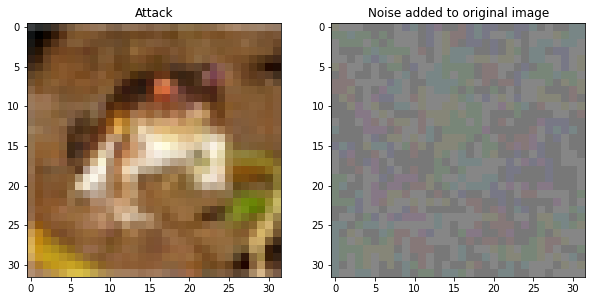

 frog
Predicted:    cat


In [22]:
s = time()
a_MIP_bounds = reluplex_accelerated_b(mlp, image_to_attack, solver=cp.GUROBI, 
                                      epsil = torch.norm(image_to_attack-a_fsgm,float('inf')).item(),
                                     target_class = pgd_target_class)
MIP_bounds_2_time = time() - s
a_MIP_bounds_2 = torch.tensor(a_MIP_bounds).reshape((3,32,32)).type(torch.float)
plot_attack_pred(image_to_attack, a_MIP_bounds_2, mlp)

[  1   3   6  12  14  16  17  18  21  28  31  33  36  38  40  41  43  46
  51  52  54  55  56  57  58  59  60  62  63  64  66  74  75  76  77  78
  79  80  81  88  93  96  98 100 101 103 105 109 113 114 116 117 118 119
 120 122 127 131 134 136 139 140 141 142 143 145 146]
[  0   4   7   8   9  10  13  19  20  22  25  32  34  37  42  44  45  47
  48  49  50  53  61  65  68  69  70  72  73  82  85  86  91  92  94  97
 102 104 106 110 111 112 115 121 125 126 128 129 130 135 137 144 147 148]
0.009000062942504883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


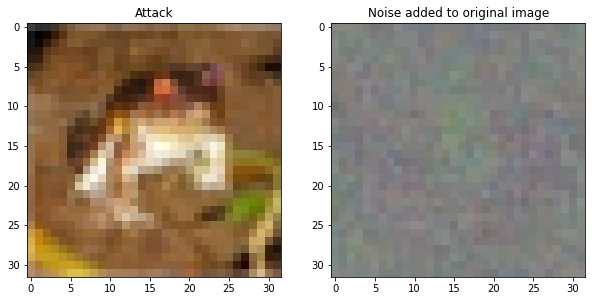

 frog
Predicted:    cat


In [23]:
s = time()
a_MIP_bounds = reluplex_accelerated_b(mlp, image_to_attack, solver=cp.GUROBI, 
                                      epsil = 1.5*torch.norm(image_to_attack-a_fsgm,float('inf')).item(),
                                      pnorm = 2)
MIP_bounds_time = time() - s
a_MIP_bounds = torch.tensor(a_MIP_bounds).reshape((3,32,32)).type(torch.float)
plot_attack_pred(image_to_attack, a_MIP_bounds, mlp)

__8. Comparison of the accuracy of the attacks and the time consumption of the methods__

In [24]:
import pandas as pd

res = pd.DataFrame(index=["Computation time","Adversarial error L2","Adversarial error L inf"])
res.loc[:, 'Evasion attack'] = (evasion_attack_time,torch.norm(image_to_attack-a_evasion).item(),
                                torch.norm(image_to_attack-a_evasion,float('inf')).item())
res.loc[:, 'FSGM'] = (fgsm_attack_time,torch.norm(image_to_attack-a_fsgm).item(),
                      torch.norm(image_to_attack-a_fsgm,float('inf')).item())
res.loc[:, 'PGD'] = (pgd_attack_time,torch.norm(image_to_attack-a_pgd).item(),
                     torch.norm(image_to_attack-a_pgd,float('inf')).item())
res.loc[:, 'Universal'] = (noise_univ_attack_time,torch.norm(noise_univ).item(),
                     torch.norm(noise_univ,float('inf')).item())
res.loc[:, 'Carlini & Wagner'] = (carlini_wagner_time,torch.norm(image_to_attack-a_cw).item(),
                                  torch.norm(image_to_attack-a_cw,float('inf')).item())
res.loc[:, 'ReLUplex'] = (reluplex_ECOS_BB_time,torch.norm(image_to_attack-a_reluplex_ECOS_BB).item(),
                          torch.norm(image_to_attack-a_reluplex_ECOS_BB,float('inf')).item())
res.loc[:, 'ReLUplex Linf'] = (reluplex_GLPK_time,torch.norm(image_to_attack-a_reluplex_GLPK).item(),
                               torch.norm(image_to_attack-a_reluplex_GLPK,float('inf')).item())
res.loc[:, 'ReLUplex with bd 2'] = (MIP_bounds_time,torch.norm(image_to_attack-a_MIP_bounds).item(),
                                      torch.norm(image_to_attack-a_MIP_bounds,float('inf')).item())
res.loc[:, 'ReLUplex with bd inf'] = (MIP_bounds_2_time,torch.norm(image_to_attack-a_MIP_bounds_2).item(),
                                      torch.norm(image_to_attack-a_MIP_bounds_2,float('inf')).item())

pd.set_option('precision', 4)
res

,Evasion attack,FSGM,PGD,Universal,Carlini & Wagner,ReLUplex,ReLUplex Linf,ReLUplex with bd 2,ReLUplex with bd inf
Computation time,0.0058,0.0027,0.2675,1.9833,0.0104,1220.5491,1129.9748,2241.7625,251.0937
Adversarial error L2,0.2791,0.3326,0.3145,1.7960,0.2908,0.2494,0.3265,0.2494,0.3128
Adversarial error L inf,0.0164,0.0060,0.0057,0.1323,0.0060,0.0153,0.0059,0.0153,0.0056


# Conclusion 

This illustration provides results coherent with thoses reported in the litterature regarding whitebox attacks (see for instance https://arxiv.org/abs/1608.04644).


As expected, the best resultas are provided by the MIP attacks (that provides the  optimal solution to the attack problem).  
Regarding computation time, the $L_2$ attack takes much more time than the $L_\infty$.   
Also, the use of bounds and precomputing some $b$ accelerate by a factor of order 2.

Compared with approximated attacks, MIP attacks takes much more computation time  ($\times 1000$). 

Regarding $L_2$ attacks,  Carlini & Wagner attack gives the best compromize performance/computing time,
while for the $L_\infty$ it's the PGD attack.

Note that for the MIP attacks, the target class is chosen as the second best which may turn out to be sub-optimal in some cases. A possible remedy would be to choose PGD adversarial class as a target.

In [25]:
print(classes[pgd_target_class])

cat
